In [1]:

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
from scipy.sparse.linalg import eigsh
from qutip import krylovsolve, Qobj

import exact
import classical

In [2]:
plt.rcParams['figure.figsize'] = (10, 3)

tmax = 5

wc = 1
wz = 1 * wc
lamc = 0.5 * np.sqrt(wc * wz)
lam = 0.5 * lamc

my0 = 0.01
#m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
m0 = np.array([1, 0, 0, 0, 0]) # m0 is the state with maximum mx
#m0 = np.array([0, 0, 1, 0, 0]) # m0 is the state with maximum mz

t_eval = np.linspace(0, tmax, 10000)
max_step = 0.01
sol = solve_ivp(classical.Dicke_classical_eqsmot, (0, tmax), m0, method='RK45', args=(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, 0.0), t_eval=t_eval, max_step=max_step)


/Users/jroman/miniconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


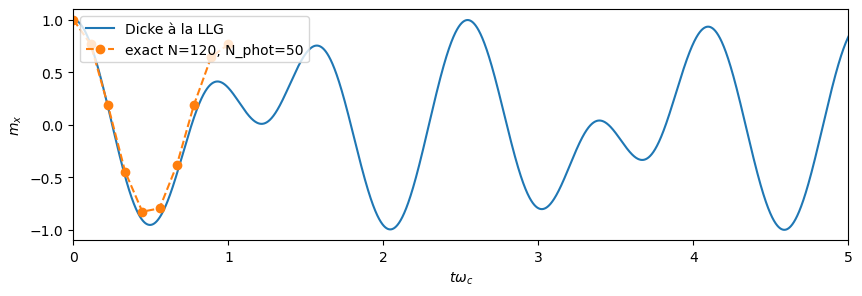

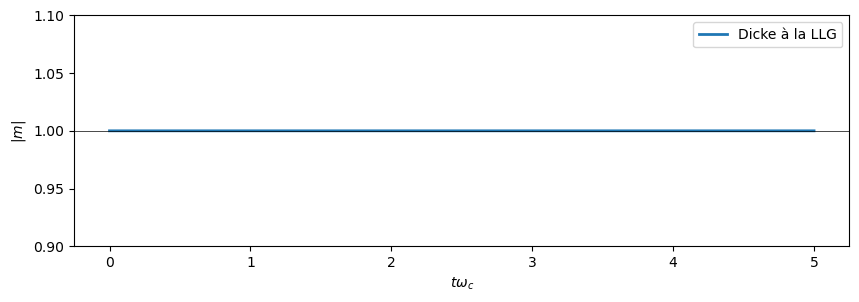

In [3]:
plt.plot(sol.t, sol.y[0], label='Dicke à la LLG')

N = 120
N_c = 50
data = np.load(f'data/mx_exact_resonance_0.5_{N}_{N_c}_1.npz')
ts = data['ts']
mxs = data['mxs']
plt.plot(ts, mxs, label=f'exact N={N}, N_phot={N_c}', marker='o', ls='dashed')
#plt.plot(t_exact, mxs_exact, label='Dicke exact', lw=0, marker='o')
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \omega_c$')
start = 0
window = 5
plt.xlim(start, start+window)
plt.legend()
plt.show()

plt.plot(sol.t, np.linalg.norm(sol.y[:3], axis=0), label='Dicke à la LLG', lw=2)
plt.ylabel(r'$|m|$')
plt.xlabel(r'$t \omega_c$')
plt.axhline(1.0, c='k', lw=0.5)
plt.ylim(0.9, 1.1)
plt.legend()
plt.show()

In [4]:
N_photons_cutoff = 100
N = 100

H = exact.dicke(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, N/2, N_photons_cutoff)
H = Qobj(H)
Sz, Sp, Sm, Seye = exact.spin_operators(N/2, to_dense_array=False)
Sx = 0.5 * (Sp + Sm)
a, ad, beye = exact.boson_operators(N_photons_cutoff, to_dense_array=False)
Sx_full = exact.krons(Sx, beye)
vals, vects = eigsh(Sx_full, k=1, which='LA')
phi0 = vects[:, -1] # phi0 is the eigenvector with maximum mxr

tlist = np.linspace(0, 1, 20)
results = krylovsolve(H, Qobj(phi0), tlist, krylov_dim=100, e_ops=Qobj(2*Sx_full/N), sparse=True)

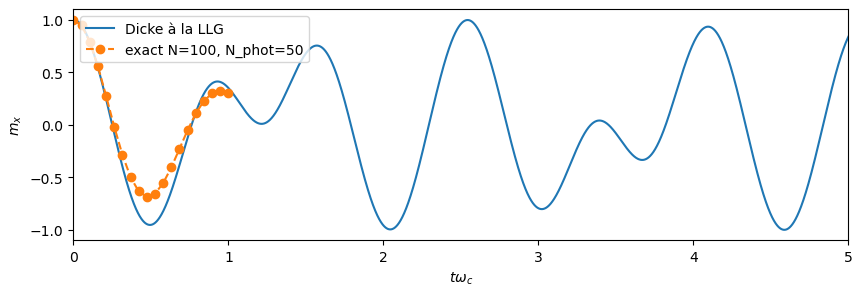

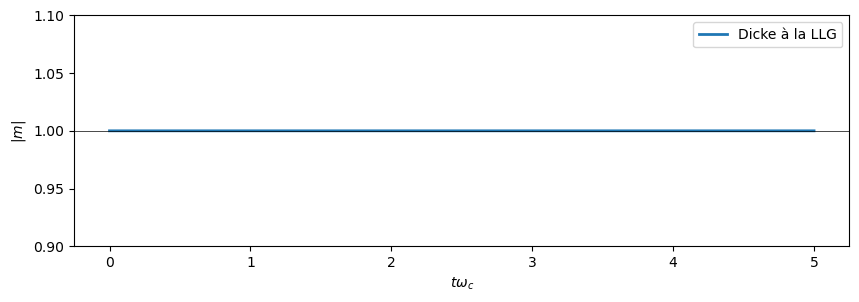

In [5]:
plt.plot(sol.t, sol.y[0], label='Dicke à la LLG')
plt.plot(tlist, results.expect[0], label=f'exact N={N}, N_phot={N_c}', marker='o', ls='dashed')
#plt.plot(t_exact, mxs_exact, label='Dicke exact', lw=0, marker='o')
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \omega_c$')
start = 0
window = 5
plt.xlim(start, start+window)
plt.legend()
plt.show()

plt.plot(sol.t, np.linalg.norm(sol.y[:3], axis=0), label='Dicke à la LLG', lw=2)
plt.ylabel(r'$|m|$')
plt.xlabel(r'$t \omega_c$')
plt.axhline(1.0, c='k', lw=0.5)
plt.ylim(0.9, 1.1)
plt.legend()
plt.show()

# Convergence as a function of Krylov subspace size

In [6]:
N_photons_cutoff = 100
N = 100
H = exact.dicke(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, N/2, N_photons_cutoff, to_dense_array=False)
H = Qobj(H)
Sz, Sp, Sm, Seye = exact.spin_operators(N/2, to_dense_array=False)
Sx = 0.5 * (Sp + Sm)
a, ad, beye = exact.boson_operators(N_photons_cutoff, to_dense_array=False)
Sx_full = exact.krons(Sx, beye)
vals, vects = eigsh(Sx_full, k=1, which='LA')
phi0 = vects[:, -1] # phi0 is the eigenvector with maximum mxr

tlist = np.linspace(0, 5, 100)
krylov_dims = np.arange(10, 200, 50)
results = []
for dim in krylov_dims:
    print(dim)
    results.append(krylovsolve(H, Qobj(phi0), tlist, krylov_dim=dim, e_ops=Qobj(2*Sx_full/N), sparse=True))

hey
hey
hey
10
60
110
160


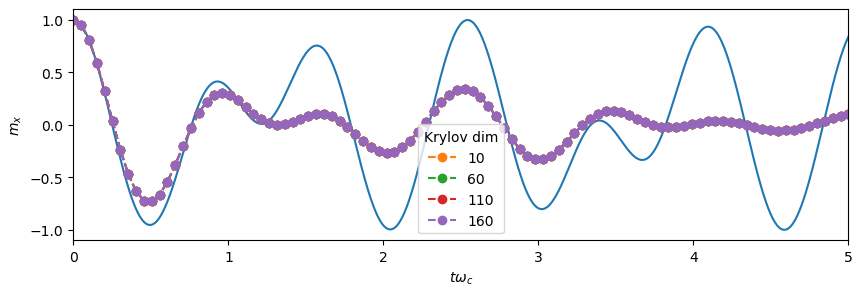

In [7]:
plt.plot(sol.t, sol.y[0])

for i, result in enumerate(results):
    plt.plot(tlist, result.expect[0], marker='o', ls='dashed', label=krylov_dims[i])
    #plt.plot(t_exact, mxs_exact, label='Dicke exact', lw=0, marker='o')
    
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \omega_c$')
start = 0
window = 5
plt.xlim(start, start+window)
plt.legend(title='Krylov dim')
plt.show()


# Convergence as a function of photon cutoff

In [10]:
N_photons_cutoffs = np.arange(1000, 1601, 200)
results = []
for N_photons_cutoff in N_photons_cutoffs:
    
    print(N_photons_cutoff)
    N = 100
    H = exact.dicke(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, N/2, N_photons_cutoff, to_dense_array=False)
    H = Qobj(H)
    Sz, Sp, Sm, Seye = exact.spin_operators(N/2, to_dense_array=False)
    Sx = 0.5 * (Sp + Sm)
    a, ad, beye = exact.boson_operators(N_photons_cutoff, to_dense_array=False)
    Sx_full = exact.krons(Sx, beye)
    vals, vects = eigsh(Sx_full, k=1, which='LA')
    phi0 = vects[:, -1] # phi0 is the eigenvector with maximum mxr

    tlist = np.linspace(0, 5, 50)
    krylov_dims = np.arange(10, 200, 50)
    
    results.append(krylovsolve(H, Qobj(phi0), tlist, krylov_dim=60, e_ops=Qobj(2*Sx_full/N), sparse=True))

1000


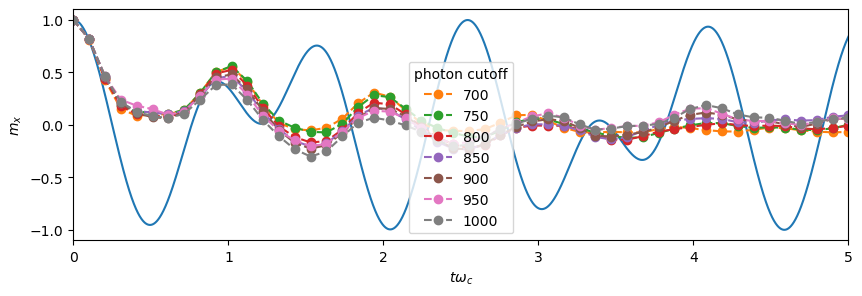

In [ ]:
plt.plot(sol.t, sol.y[0])

for i, result in enumerate(results):
    plt.plot(tlist, result.expect[0], marker='o', ls='dashed', label=N_photons_cutoffs[i])
    #plt.plot(t_exact, mxs_exact, label='Dicke exact', lw=0, marker='o')
    
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \omega_c$')
start = 0
window = 5
plt.xlim(start, start+window)
plt.legend(title='photon cutoff')
plt.show()


# Convergence as a function of number of spins

In [24]:
N_photons_cutoff = 100
Ns = np.arange(600, 1300, 200)
results = []
for N in Ns:
    
    print(N)
    H = exact.dicke(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, N/2, N_photons_cutoff, to_dense_array=False)
    H = Qobj(H)
    Sz, Sp, Sm, Seye = exact.spin_operators(N/2, to_dense_array=False)
    Sx = 0.5 * (Sp + Sm)
    a, ad, beye = exact.boson_operators(N_photons_cutoff, to_dense_array=False)
    Sx_full = exact.krons(Sx, beye)
    vals, vects = eigsh(Sx_full, k=1, which='LA')
    phi0 = vects[:, -1] # phi0 is the eigenvector with maximum mxr

    tlist = np.linspace(0, 5, 50)
    krylov_dims = np.arange(10, 200, 50)
    
    results.append(krylovsolve(H, Qobj(phi0), tlist, krylov_dim=60, e_ops=Qobj(2*Sx_full/N), sparse=True))

600
800
1000
1200


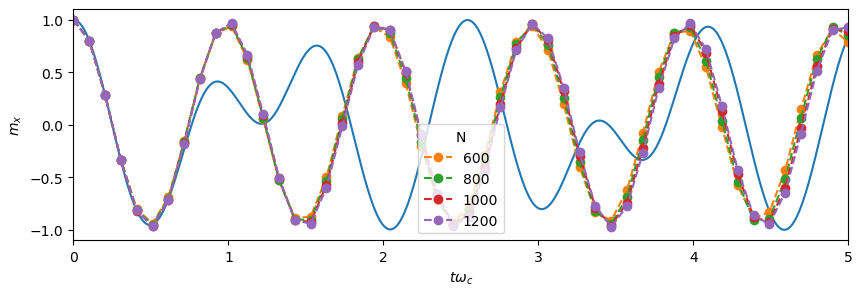

In [25]:
plt.plot(sol.t, sol.y[0])

for i, result in enumerate(results):
    plt.plot(tlist, result.expect[0], marker='o', ls='dashed', label=Ns[i])
    #plt.plot(t_exact, mxs_exact, label='Dicke exact', lw=0, marker='o')
    
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \omega_c$')
start = 0
window = 5
plt.xlim(start, start+window)
plt.legend(title='N')
plt.show()


# Test with Polaron

In [ ]:
N_photons_cutoff = 100
Ns = np.arange(600, 1300, 200)
results = []
for N in Ns:
    
    print(N)
    H = exact.Dicke_polaron(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, 0.0, N/2, N_photons_cutoff, to_dense_array=False)
    H = Qobj(H)
    Sz, Sp, Sm, Seye = exact.spin_operators(N/2, to_dense_array=False)
    Sx = 0.5 * (Sp + Sm)
    a, ad, beye = exact.boson_operators(N_photons_cutoff, to_dense_array=False)
    Sx_full = exact.krons(Sx, beye)
    vals, vects = eigsh(Sx_full, k=1, which='LA')
    phi0 = vects[:, -1] # phi0 is the eigenvector with maximum mxr

    tlist = np.linspace(0, 5, 50)
    krylov_dims = np.arange(10, 200, 50)
    
    results.append(krylovsolve(H, Qobj(phi0), tlist, krylov_dim=60, e_ops=Qobj(2*Sx_full/N), sparse=True))

100
200
300
400


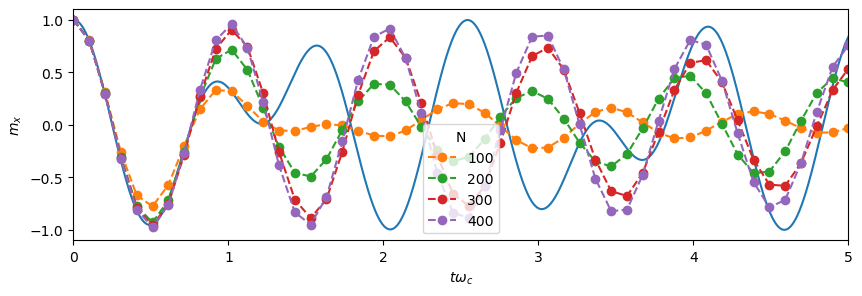

In [ ]:
plt.plot(sol.t, sol.y[0])

for i, result in enumerate(results):
    plt.plot(tlist, result.expect[0], marker='o', ls='dashed', label=Ns[i])
    #plt.plot(t_exact, mxs_exact, label='Dicke exact', lw=0, marker='o')
    
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \omega_c$')
start = 0
window = 5
plt.xlim(start, start+window)
plt.legend(title='N')
plt.show()


# Ultimate test

In [ ]:
N_photons_cutoff = 1000
N = 1000
results = []

H = exact.dicke(2*np.pi * wz, 2*np.pi * wc, 2*np.pi * lam, N/2, N_photons_cutoff, to_dense_array=False)
H = Qobj(H)
Sz, Sp, Sm, Seye = exact.spin_operators(N/2, to_dense_array=False)
Sx = 0.5 * (Sp + Sm)
a, ad, beye = exact.boson_operators(N_photons_cutoff, to_dense_array=False)
Sx_full = exact.krons(Sx, beye)
vals, vects = eigsh(Sx_full, k=1, which='LA')
phi0 = vects[:, -1] # phi0 is the eigenvector with maximum mxr

tlist = np.linspace(0, 5, 50)
krylov_dims = np.arange(10, 200, 50)

results.append(krylovsolve(H, Qobj(phi0), tlist, krylov_dim=60, e_ops=Qobj(2*Sx_full/N), sparse=True))

In [ ]:
plt.plot(sol.t, sol.y[0])

for i, result in enumerate(results):
    plt.plot(tlist, result.expect[0], marker='o', ls='dashed')
    #plt.plot(t_exact, mxs_exact, label='Dicke exact', lw=0, marker='o')
    
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \omega_c$')
start = 0
window = 5
plt.xlim(start, start+window)
plt.legend(title='N')
plt.show()
